## This file aims to forecast Citi Bike rentals using a dataset spanning from 2016 to 2024.

## Import necessary Libraries

In [1]:
#install necessary packages
!pip install seaborn
!pip install prophet
!pip install scikit-learn
!pip install plotly
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: unknown command "install scikit-learn"
Defaulting to user installation because normal site-packages is not writeable
ERROR: unknown command "install ipywidgets"


In [2]:
# importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, count, date_format, to_date, year, unix_timestamp, round, avg, sum, hour, dayofweek, lit
from pyspark.sql.types import StructType, StructField, StringType, DecimalType, BooleanType, FloatType, DoubleType, TimestampType, IntegerType

sns.set_style('whitegrid')

In [3]:
!echo $SPARK_MASTER_ADDRESS

spark://notch081.ipoib.int.chpc.utah.edu:7080


In [4]:
!echo $SPARK_MASTER_OOD_ADDRESS
!echo $SPARK_WORKER1_OOD_ADDRESS
!echo $SPARK_WORKER2_OOD_ADDRESS

https://ondemand-class.chpc.utah.edu/rnode/notch081.ipoib.int.chpc.utah.edu/8086
https://ondemand-class.chpc.utah.edu/rnode/notch081.ipoib.int.chpc.utah.edu/8087
https://ondemand-class.chpc.utah.edu/rnode/notch082.ipoib.int.chpc.utah.edu/8084


In [5]:
from pyspark.sql import SparkSession
import os
spark = SparkSession.builder \
    .master(os.getenv('SPARK_MASTER_ADDRESS')) \
    .appName("Spark-application") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/30 20:51:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/30 20:51:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/30 20:51:46 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/04/30 20:51:46 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


### Manual inspection of dataset for each year from 2016-2024

In [6]:
directory_path = "data/8_years"

# Get a list of all CSV files in the directory
csv_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith(".csv")]

In [7]:
data_2016 = 'data/8_years/JC-201601-citibike-tripdata.csv'
data_2017 = 'data/8_years/JC-201701-citibike-tripdata.csv'
data_2018 = 'data/8_years/JC-201801-citibike-tripdata.csv'
data_2019 = 'data/8_years/JC-201901-citibike-tripdata.csv'
data_2020 = 'data/8_years/JC-202001-citibike-tripdata.csv'
data_2021 = 'data/8_years/JC-202101-citibike-tripdata.csv'
data_2022 = 'data/8_years/JC-202201-citibike-tripdata.csv'
data_2023 = 'data/8_years/JC-202301-citibike-tripdata.csv'
data_2024 = 'data/8_years/JC-202401-citibike-tripdata.csv'

data_years = [data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022, data_2023, data_2024]
for years in data_years:
    objects = spark.read.csv(years, sep=',',inferSchema=True, header=True)
    print(years)
    objects.printSchema()

data/8_years/JC-201601-citibike-tripdata.csv
root
 |-- Trip Duration: integer (nullable = true)
 |-- Start Time: timestamp (nullable = true)
 |-- Stop Time: timestamp (nullable = true)
 |-- Start Station ID: integer (nullable = true)
 |-- Start Station Name: string (nullable = true)
 |-- Start Station Latitude: double (nullable = true)
 |-- Start Station Longitude: double (nullable = true)
 |-- End Station ID: integer (nullable = true)
 |-- End Station Name: string (nullable = true)
 |-- End Station Latitude: double (nullable = true)
 |-- End Station Longitude: double (nullable = true)
 |-- Bike ID: integer (nullable = true)
 |-- User Type: string (nullable = true)
 |-- Birth Year: integer (nullable = true)
 |-- Gender: integer (nullable = true)



data/8_years/JC-201701-citibike-tripdata.csv
root
 |-- Trip Duration: integer (nullable = true)
 |-- Start Time: timestamp (nullable = true)
 |-- Stop Time: timestamp (nullable = true)
 |-- Start Station ID: integer (nullable = true)
 |-- Start Station Name: string (nullable = true)
 |-- Start Station Latitude: double (nullable = true)
 |-- Start Station Longitude: double (nullable = true)
 |-- End Station ID: integer (nullable = true)
 |-- End Station Name: string (nullable = true)
 |-- End Station Latitude: double (nullable = true)
 |-- End Station Longitude: double (nullable = true)
 |-- Bike ID: integer (nullable = true)
 |-- User Type: string (nullable = true)
 |-- Birth Year: integer (nullable = true)
 |-- Gender: integer (nullable = true)

data/8_years/JC-201801-citibike-tripdata.csv
root
 |-- tripduration: integer (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start station id: integer (nullable = true)
 |-- start s

data/8_years/JC-202001-citibike-tripdata.csv
root
 |-- tripduration: integer (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start station id: integer (nullable = true)
 |-- start station name: string (nullable = true)
 |-- start station latitude: double (nullable = true)
 |-- start station longitude: double (nullable = true)
 |-- end station id: integer (nullable = true)
 |-- end station name: string (nullable = true)
 |-- end station latitude: double (nullable = true)
 |-- end station longitude: double (nullable = true)
 |-- bikeid: integer (nullable = true)
 |-- usertype: string (nullable = true)
 |-- birth year: integer (nullable = true)
 |-- gender: integer (nullable = true)

data/8_years/JC-202101-citibike-tripdata.csv
root
 |-- tripduration: integer (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start station id: integer (nullable = true)
 |-- start statio

data/8_years/JC-202301-citibike-tripdata.csv
root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)

data/8_years/JC-202401-citibike-tripdata.csv
root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_sta

#### As we can see the dataset in inconsistent in column names. Hence, we need some data preprocessing before preparing our final merged dataset.

#### Identical columns as per need: {"starttime" : "started_at", "start time" : "started_at", "stoptime": "ended_at", "stop time": "ended_at", "start station name" : "start_station_name", "end station name" : "end_station_name", start station latitude", "start_lat","end station latitude", "end_lat", "start station longitude", "start_lng" , "end station longitude", "end_lng"}

#### After preprocessing, We created a merged dataframe by merging all the csv present in our dataset. We have also done feature engineering so that we only consider those column which is needed for our task.

In [8]:
start_time = datetime.now()

# Read the first CSV file to create the initial DataFrame
objects = spark.read.csv(csv_files[0], header=True, inferSchema=True)

# Rename the files to make them consistent
objects = objects.withColumnRenamed("starttime", "started_at") \
                 .withColumnRenamed("start time", "started_at") \
                 .withColumnRenamed("stoptime", "ended_at") \
                 .withColumnRenamed("stop time", "ended_at") \
                 .withColumnRenamed("start station name", "start_station_name") \
                 .withColumnRenamed("end station name", "end_station_name") \
                 .withColumnRenamed("start station latitude", "start_lat") \
                 .withColumnRenamed("end station latitude", "end_lat") \
                 .withColumnRenamed("start station longitude", "start_lng") \
                 .withColumnRenamed("end station longitude", "end_lng") 

# Feature engineering to select only need columns
objects=objects.select("started_at","ended_at","start_station_name","end_station_name","start_lat","start_lng","end_lat","end_lng")

# Loop through the remaining CSV files and union them with the initial DataFrame
for file in csv_files[1:]:
    objects_temp = spark.read.csv(file, header=True, inferSchema=True)

    # Rename the files to make them consistent
    objects_temp = objects_temp.withColumnRenamed("starttime", "started_at") \
                 .withColumnRenamed("stoptime", "ended_at") \
                 .withColumnRenamed("start time", "started_at") \
                 .withColumnRenamed("stop time", "ended_at") \
                 .withColumnRenamed("start station name", "start_station_name") \
                 .withColumnRenamed("end station name", "end_station_name") \
                 .withColumnRenamed("start station latitude", "start_lat") \
                 .withColumnRenamed("end station latitude", "end_lat") \
                 .withColumnRenamed("start station longitude", "start_lng") \
                 .withColumnRenamed("end station longitude", "end_lng") 

    # Feature engineering to select only need columns
    objects_temp=objects_temp.select("started_at","ended_at","start_station_name","end_station_name","start_lat","start_lng","end_lat","end_lng")

    #Merging the dataframe
    objects = objects.union(objects_temp)

end_time = datetime.now()

# Show the merged dataframe
objects.show()

+-------------------+-------------------+------------------+----------------+-----------------+------------------+------------+-------------+
|         started_at|           ended_at|start_station_name|end_station_name|        start_lat|         start_lng|     end_lat|      end_lng|
+-------------------+-------------------+------------------+----------------+-----------------+------------------+------------+-------------+
|2016-01-01 00:02:52|2016-01-01 00:08:54|     Grove St PATH|    Brunswick St|40.71958611647166|-74.04311746358871|  40.7241765|  -74.0506564|
|2016-01-01 00:18:22|2016-01-01 00:21:42|     Grove St PATH|  Van Vorst Park|40.71958611647166|-74.04311746358871| 40.71848892|-74.047726625|
|2016-01-01 00:18:25|2016-01-01 00:21:47|     Grove St PATH|  Van Vorst Park|40.71958611647166|-74.04311746358871| 40.71848892|-74.047726625|
|2016-01-01 00:23:13|2016-01-01 00:27:21|      Brunswick St|   Hamilton Park|       40.7241765|       -74.0506564|40.727595966|-74.044247311|
|2016-

In [9]:
# Time required for data preprocessing and preparing the datafram
print("Time required for data preparation", (end_time - start_time))

Time required for data preparation 0:00:50.019574


In [10]:
objects.printSchema()

# Display the count of records
print("Number of records:", objects.count())

root
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)



Number of records: 4273206


### Data Cleaning:

#### We check for null values in our dataframe and remove those records from dataframe.

In [11]:
start_time = datetime.now()

null_counts_per_column = {}

# Iterate over each column and count null values
for column in objects.columns:
    null_count = objects.filter(col(column).isNull()).count()
    null_counts_per_column[column] = null_count

for column, cnt in null_counts_per_column.items():
    print(f"Column '{column}': {cnt} null values")

Column 'started_at': 0 null values
Column 'ended_at': 0 null values
Column 'start_station_name': 102 null values
Column 'end_station_name': 10319 null values
Column 'start_lat': 0 null values
Column 'start_lng': 0 null values
Column 'end_lat': 5193 null values
Column 'end_lng': 5193 null values


In [12]:
objects = objects.dropna()   # drop null values if any

print("Number of records after data cleaning:", objects.count())

Number of records after data cleaning: 4262867


#### Next, We calculate the duration of each ride in seconds by taking time difference between started_at time and ended_at time. We further ignore those rides having a ride duration less than a minute to ensure the accuracy and relevance of the analysis, as very short durations might not provide meaningful insights into bike usage patterns or user behavior.

In [13]:
# Convert 'started_at' and 'ended_at' columns to timestamps
objects = objects.withColumn('started_at', unix_timestamp(col('started_at'), 'yyyy-MM-dd HH:mm:ss').cast("timestamp"))
objects = objects.withColumn('ended_at', unix_timestamp(col('ended_at'), 'yyyy-MM-dd HH:mm:ss').cast("timestamp"))

# Calculate duration of each ride in seconds
objects = objects.withColumn('total_ride_duration_seconds', (col('ended_at').cast('long') - col('started_at').cast('long')))

objects.show()

+-------------------+-------------------+------------------+----------------+-----------------+------------------+------------+-------------+---------------------------+
|         started_at|           ended_at|start_station_name|end_station_name|        start_lat|         start_lng|     end_lat|      end_lng|total_ride_duration_seconds|
+-------------------+-------------------+------------------+----------------+-----------------+------------------+------------+-------------+---------------------------+
|2016-01-01 00:02:52|2016-01-01 00:08:54|     Grove St PATH|    Brunswick St|40.71958611647166|-74.04311746358871|  40.7241765|  -74.0506564|                        362|
|2016-01-01 00:18:22|2016-01-01 00:21:42|     Grove St PATH|  Van Vorst Park|40.71958611647166|-74.04311746358871| 40.71848892|-74.047726625|                        200|
|2016-01-01 00:18:25|2016-01-01 00:21:47|     Grove St PATH|  Van Vorst Park|40.71958611647166|-74.04311746358871| 40.71848892|-74.047726625|         

24/04/30 20:55:22 WARN DAGScheduler: Broadcasting large task binary with size 1013.6 KiB


In [14]:
# # Filter records with less than 1 minute duration and ignore this rides
# short_duration_rides = objects.filter(col('total_ride_duration_seconds') < 60)
# short_duration_rides.count()

In [15]:
# cosidering only ride having total_ride_duration_seconds > 1 min (60 sec) 
objects = objects.filter(col('total_ride_duration_seconds') >= 60)
objects.count()

4205954

In [16]:
end_time = datetime.now()

In [17]:
# Time required for data preprocessing and preparing the datafram
print("Time required for data cleaning:", (end_time - start_time))

Time required for data cleaning: 0:02:11.897384


# Exploratory data analysis

In this section, We address key inquiries posed by Citi Bike such as 
1. Where do Citi Bikers ride? 
2. When do they ride? 
3. How far do they go?
4. Which stations are most popular? 
5. What days of the week are most rides taken on?

## 1. Where do Citi Bikers ride? (Popular start and end stations)

In [18]:
start_time = datetime.now()

In [19]:
# We group by start station name and count the number of rides
start_station_counts = objects.groupBy('start_station_name').count().orderBy('count', ascending=False)

# We group by end station name and count the number of rides
end_station_counts = objects.groupBy('end_station_name').count().orderBy('count', ascending=False)

start_station_counts.show(10)   # top 10 starting stations
end_station_counts.show(10)     # top 10 ending stations

24/04/30 20:55:46 WARN DAGScheduler: Broadcasting large task binary with size 1100.8 KiB


+--------------------+------+
|  start_station_name| count|
+--------------------+------+
|       Grove St PATH|295248|
|       Hamilton Park|156822|
|        Newport PATH|133964|
|        Newport Pkwy|123521|
|             Sip Ave|110274|
|    Marin Light Rail|104274|
|Hoboken Terminal ...| 98216|
|South Waterfront ...| 91683|
|          Harborside| 91123|
|  Liberty Light Rail| 90446|
+--------------------+------+
only showing top 10 rows



24/04/30 20:56:14 WARN DAGScheduler: Broadcasting large task binary with size 1100.7 KiB


+--------------------+------+
|    end_station_name| count|
+--------------------+------+
|       Grove St PATH|348954|
|       Hamilton Park|152514|
|        Newport PATH|136870|
|        Newport Pkwy|123607|
|    Marin Light Rail|103218|
|             Sip Ave|102556|
|Hoboken Terminal ...| 95092|
|  Liberty Light Rail| 93176|
|South Waterfront ...| 93005|
|           City Hall| 91116|
+--------------------+------+
only showing top 10 rows



## 2. When do they ride? (Distribution of rides by time of day)

24/04/30 20:56:42 WARN DAGScheduler: Broadcasting large task binary with size 1177.3 KiB


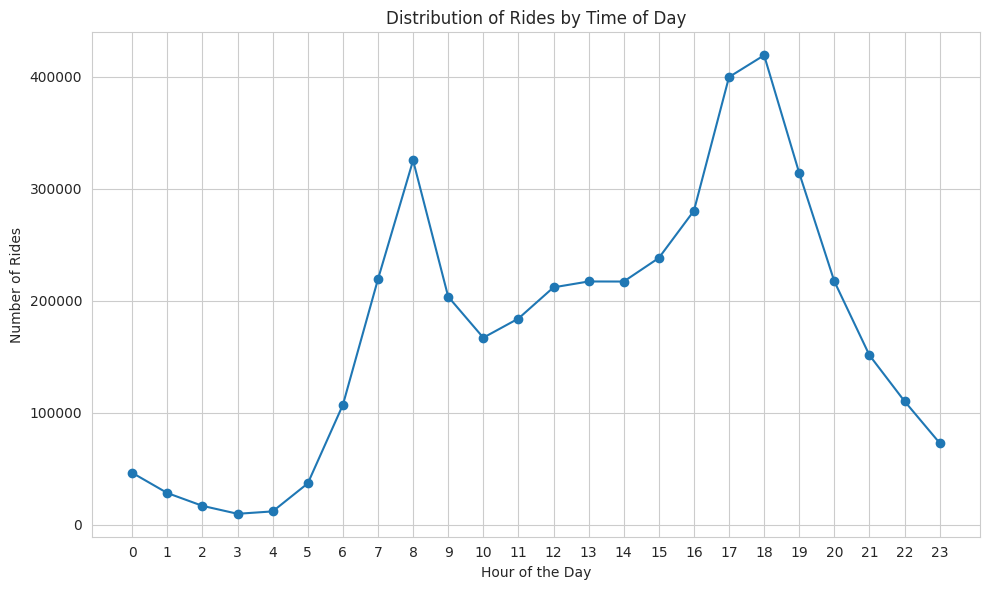

In [20]:
# As we need at what time do they ride, we first extract hour from the 'started_at' timestamp
objects = objects.withColumn('hour', hour('started_at'))

# next, we group by hour and count the number of rides
ride_hours = objects.groupBy('hour').count().orderBy('hour')

#convert to pandas
ride_hours_pd = ride_hours.toPandas()

# distribution of rides by time of day
plt.figure(figsize=(10, 6))
plt.plot(ride_hours_pd['hour'], ride_hours_pd['count'], marker='o', linestyle='-')
plt.title('Distribution of Rides by Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.xticks(range(24)) 
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. How far do they go? (Average distance traveled per ride)

In [21]:
# distance traveled using start and end coordinates. The multiplication by 111.32 is used to convert the difference in latitude and longitude coordinates from degrees to kilometers.
objects = objects.withColumn('distance_km', lit(111.32) * (col('end_lat') - col('start_lat')) + lit(111.32) * (col('end_lng') - col('start_lng')) * col('end_lat'))

# average distance traveled per ride
average_distance = objects.agg({'distance_km': 'avg'}).collect()[0][0]

print("Average distance traveled per ride:", average_distance, "km")

Average distance traveled per ride: 0.7828641087749626 km


## 4. Which stations are most popular? (Top start and end stations)

In [22]:
start_station_counts.show(10)   # top 10 starting stations
end_station_counts.show(10)     # top 10 ending stations

24/04/30 20:57:23 WARN DAGScheduler: Broadcasting large task binary with size 1100.9 KiB


+--------------------+------+
|  start_station_name| count|
+--------------------+------+
|       Grove St PATH|295248|
|       Hamilton Park|156822|
|        Newport PATH|133964|
|        Newport Pkwy|123521|
|             Sip Ave|110274|
|    Marin Light Rail|104274|
|Hoboken Terminal ...| 98216|
|South Waterfront ...| 91683|
|          Harborside| 91123|
|  Liberty Light Rail| 90446|
+--------------------+------+
only showing top 10 rows



24/04/30 20:57:45 WARN DAGScheduler: Broadcasting large task binary with size 1100.8 KiB


+--------------------+------+
|    end_station_name| count|
+--------------------+------+
|       Grove St PATH|348954|
|       Hamilton Park|152514|
|        Newport PATH|136870|
|        Newport Pkwy|123607|
|    Marin Light Rail|103218|
|             Sip Ave|102556|
|Hoboken Terminal ...| 95092|
|  Liberty Light Rail| 93176|
|South Waterfront ...| 93005|
|           City Hall| 91116|
+--------------------+------+
only showing top 10 rows



## 5. What days of the week are most rides taken on? (Distribution of rides by day of the week)

24/04/30 20:58:06 WARN DAGScheduler: Broadcasting large task binary with size 1210.4 KiB


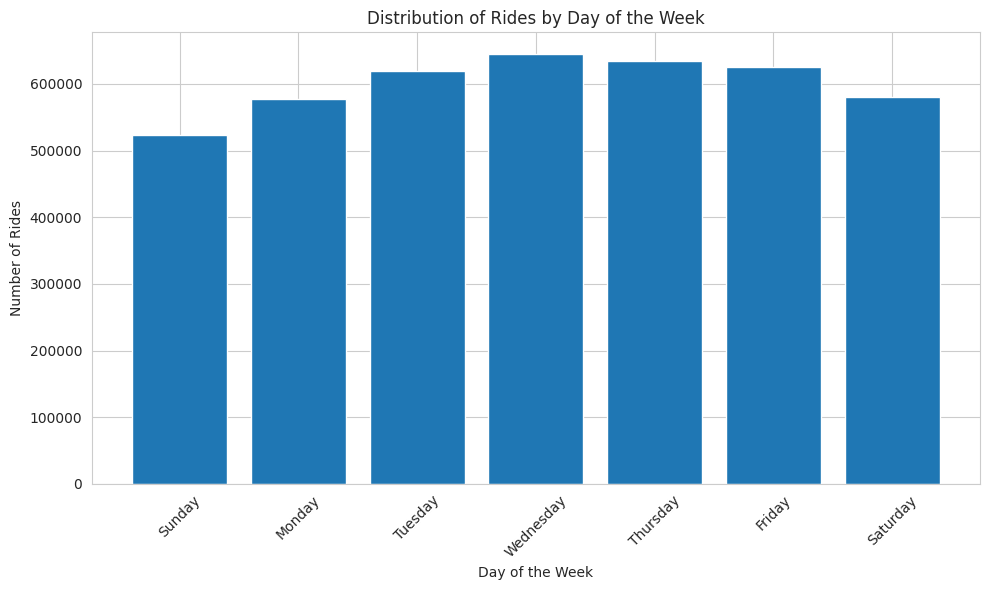

In [23]:
# Extract day of the week from the 'started_at' timestamp (1: Sunday, 2: Monday, ..., 7: Saturday)
objects = objects.withColumn('day_of_week', dayofweek('started_at'))

# Group by day of the week and count the number of rides
ride_days = objects.groupBy('day_of_week').count().orderBy('day_of_week')

# Convert DataFrame to Pandas DataFrame for plotting
ride_days_pd = ride_days.toPandas()

# Define the mapping of day of the week numbers to day names
day_names = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Map day of the week numbers to day names for better visualization
ride_days_pd['day_of_week'] = ride_days_pd['day_of_week'].map(day_names)

# Plot distribution of rides by day of the week
plt.figure(figsize=(10, 6))
plt.bar(ride_days_pd['day_of_week'], ride_days_pd['count'])
plt.title('Distribution of Rides by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
end_time = datetime.now()
# Time required for data preprocessing and preparing the datafram
print("Time required for data cleaning:", (end_time - start_time))

Time required for data cleaning: 0:02:43.825403


#### Now we will start with forecasting. First, we will do feature engineering to consider the columns needed for our prophet model. Next, we will convert the dataframe into the form which we can feed it to phophet.

In [25]:
objects = objects.withColumn('started_at', date_format(col('started_at'), 'yyyy-MM-dd'))  
objects.printSchema()

root
 |-- started_at: string (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- total_ride_duration_seconds: long (nullable = true)
 |-- hour: integer (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [26]:
# count number of rides on each start date
df = objects.groupBy('started_at').agg(count('*').alias('trips'))

# Sorting the dataFrame by date in ascending order
df = df.orderBy('started_at')

In [27]:
df.show()

24/04/30 20:58:28 WARN DAGScheduler: Broadcasting large task binary with size 1189.5 KiB


+----------+-----+
|started_at|trips|
+----------+-----+
|2016-01-01|  163|
|2016-01-02|  207|
|2016-01-03|  276|
|2016-01-04|  286|
|2016-01-05|  273|
|2016-01-06|  353|
|2016-01-07|  442|
|2016-01-08|  422|
|2016-01-09|  294|
|2016-01-10|  206|
|2016-01-11|  339|
|2016-01-12|  367|
|2016-01-13|  325|
|2016-01-14|  341|
|2016-01-15|  427|
|2016-01-16|  288|
|2016-01-17|  164|
|2016-01-18|  160|
|2016-01-19|  269|
|2016-01-20|  367|
+----------+-----+
only showing top 20 rows



In [28]:
# convert the dataframe into needed form by prophet
df=df.withColumnRenamed('started_at', 'ds').withColumnRenamed('trips', 'y')
df.show()

24/04/30 20:58:49 WARN DAGScheduler: Broadcasting large task binary with size 1189.5 KiB


+----------+---+
|        ds|  y|
+----------+---+
|2016-01-01|163|
|2016-01-02|207|
|2016-01-03|276|
|2016-01-04|286|
|2016-01-05|273|
|2016-01-06|353|
|2016-01-07|442|
|2016-01-08|422|
|2016-01-09|294|
|2016-01-10|206|
|2016-01-11|339|
|2016-01-12|367|
|2016-01-13|325|
|2016-01-14|341|
|2016-01-15|427|
|2016-01-16|288|
|2016-01-17|164|
|2016-01-18|160|
|2016-01-19|269|
|2016-01-20|367|
+----------+---+
only showing top 20 rows



## Visualization of Time Series Data

24/04/30 20:59:08 WARN DAGScheduler: Broadcasting large task binary with size 1189.5 KiB


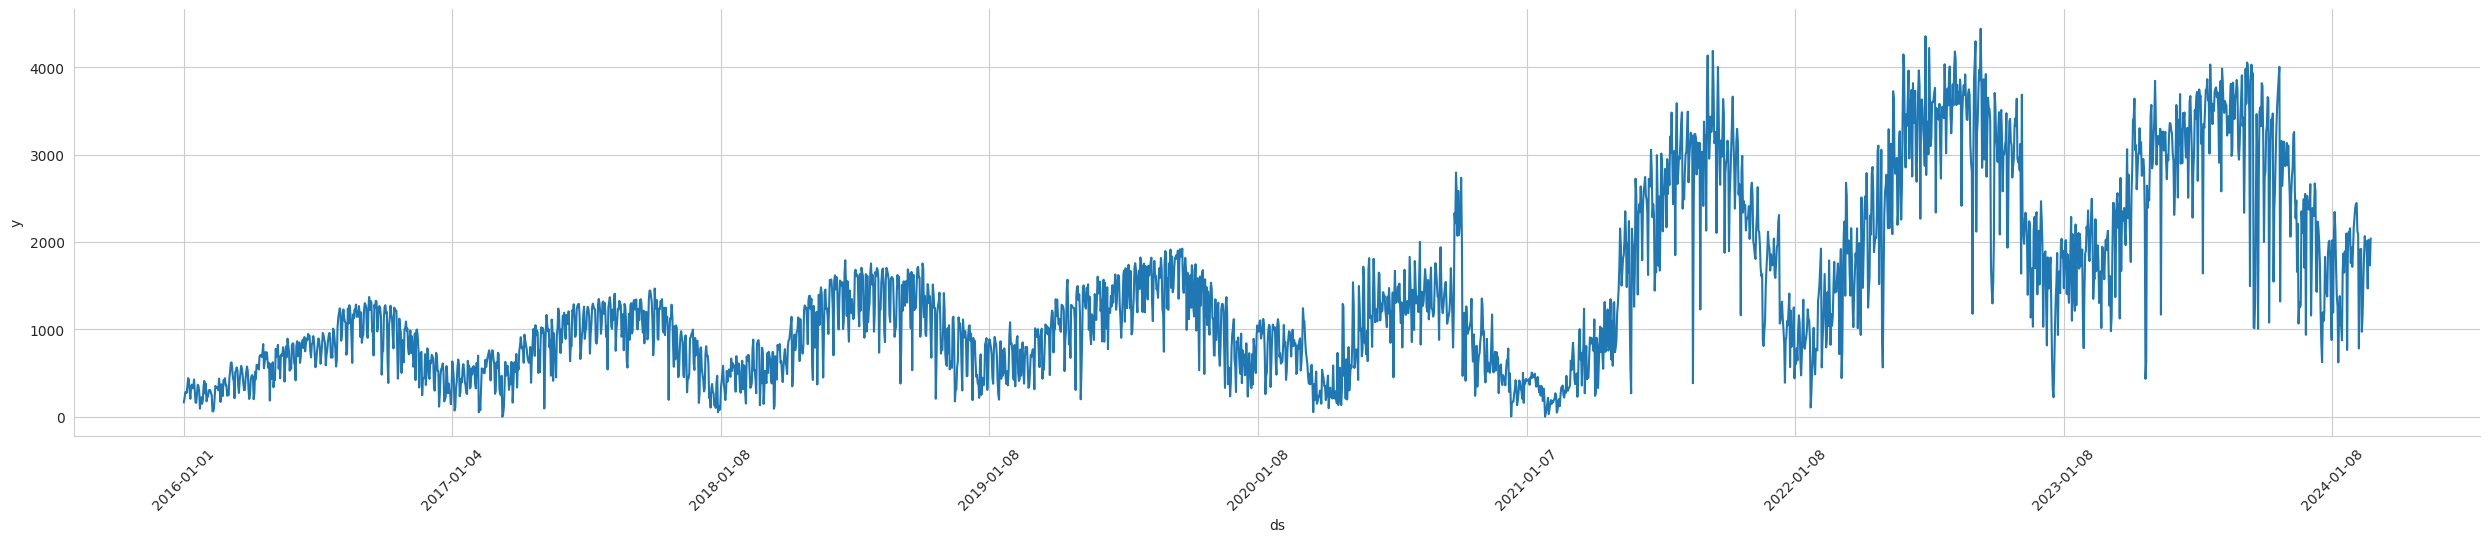

In [29]:
trips_df_pd=df.toPandas()
g = sns.relplot(x="ds", y="y", kind="line", data=trips_df_pd, aspect=5)

x_ticks = trips_df_pd['ds'][::365]   # to display every year
g.set(xticks=x_ticks)

plt.xticks(rotation=45)

plt.show()
g.fig.autofmt_xdate()

In [30]:
len(trips_df_pd)   # Records in the dataset

2973

In [31]:
trips_df_pd['ds'] = pd.to_datetime(trips_df_pd['ds'])

## Time Series Forecasting

### Preparing Dataset

In [32]:
# We first divide our dataset such that we take rides from 2024 as part of testing data and rest as training data

train_data = trips_df_pd[trips_df_pd['ds'].dt.year != 2024]
test_data = trips_df_pd[trips_df_pd['ds'].dt.year == 2024]

print("Training Dataset Size:", len(train_data))
print("Testing Dataset Size:", len(test_data))

Training Dataset Size: 2913
Testing Dataset Size: 60


In [33]:
train_data.head()   # Training data (2021-2023)

ds    y
0 2016-01-01  163
1 2016-01-02  207
2 2016-01-03  276
3 2016-01-04  286
4 2016-01-05  273

In [34]:
train_data.tail() 

ds     y
2908 2023-12-27  1095
2909 2023-12-28  1204
2910 2023-12-29  1830
2911 2023-12-30  1499
2912 2023-12-31  1425

In [35]:
test_data.head()   # Testing data (2024)

ds     y
2913 2024-01-01  1377
2914 2024-01-02  1873
2915 2024-01-03  2002
2916 2024-01-04  2015
2917 2024-01-05  1826

In [36]:
test_data.tail()

ds     y
2968 2024-02-25  1469
2969 2024-02-26  2025
2970 2024-02-27  1900
2971 2024-02-28  1733
2972 2024-02-29  2042

### Training Prophet Model

In [37]:
model=Prophet()
model.fit(train_data)

20:59:43 - cmdstanpy - INFO - Chain [1] start processing
20:59:44 - cmdstanpy - INFO - Chain [1] done processing


### Forcasting using Trained Prophet Model

In [38]:
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

In [39]:
forecast.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-01-01  645.724656 -606.859502  473.031160   645.724656   645.724656   
1 2016-01-02  645.978954 -705.056672  408.583234   645.978954   645.978954   
2 2016-01-03  646.233252 -865.139639  282.824440   646.233252   646.233252   
3 2016-01-04  646.487550 -644.445353  427.996850   646.487550   646.487550   
4 2016-01-05  646.741848 -564.667262  533.438089   646.741848   646.741848   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0     -687.487877           -687.487877           -687.487877   58.614306   
1     -785.413989           -785.413989           -785.413989  -46.034103   
2     -906.544782           -906.544782           -906.544782 -175.902147   
3     -778.562512           -778.562512           -778.562512  -58.449041   
4     -659.905301           -659.905301           -659.905301   48.143650   

   weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0     58.614306     58.614306 -746.102183   -746.102183   -746.102183   
1    -46.034103    -46.034103 -739.379886   -739.379886   -739.379886   
2   -175.902147   -175.902147 -730.642635   -730.642635   -730.642635   
3    -58.449041    -58.449041 -720.113471   -720.113471   -720.113471   
4     48.143650     48.143650 -708.048951   -708.048951   -708.048951   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  -41.763221  
1                         0.0 -139.435035  
2                         0.0 -260.311530  
3                         0.0 -132.074962  
4                         0.0  -13.163453

In [40]:
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
2968 2024-02-25  2744.264982  1495.255191  2610.299819  2740.242427   
2969 2024-02-26  2744.668011  1610.596617  2759.316664  2740.326039   
2970 2024-02-27  2745.071040  1726.018057  2880.319624  2740.587281   
2971 2024-02-28  2745.474069  1766.103091  2910.782419  2740.880691   
2972 2024-02-29  2745.877098  1755.932280  2887.224778  2741.024933   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
2968  2749.602697     -678.581620           -678.581620           -678.581620   
2969  2750.325075     -555.741260           -555.741260           -555.741260   
2970  2750.960182     -444.850095           -444.850095           -444.850095   
2971  2751.640890     -387.588778           -387.588778           -387.588778   
2972  2752.242944     -416.238444           -416.238444           -416.238444   

          weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
2968 -175.902147   -175.902147   -175.902147 -502.679473   -502.679473   
2969  -58.449041    -58.449041    -58.449041 -497.292219   -497.292219   
2970   48.143650     48.143650     48.143650 -492.993745   -492.993745   
2971  102.202907    102.202907    102.202907 -489.791685   -489.791685   
2972   71.424428     71.424428     71.424428 -487.662873   -487.662873   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
2968   -502.679473                   0.0                         0.0   
2969   -497.292219                   0.0                         0.0   
2970   -492.993745                   0.0                         0.0   
2971   -489.791685                   0.0                         0.0   
2972   -487.662873                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
2968                         0.0  2065.683362  
2969                         0.0  2188.926751  
2970                         0.0  2300.220945  
2971                         0.0  2357.885291  
2972                         0.0  2329.638654

'ds': represents the dates for which the forecasted values are provided. \
'yhat': contains the forecasted values (predictions) for each corresponding date in the 'ds' column. \
'yhat_lower': contains the lower bound of the uncertainty interval for each forecasted value. It represents the lower bound of the prediction's confidence interval. \
'yhat_upper': contains the upper bound of the uncertainty interval for each forecasted value. It represents the upper bound of the prediction's confidence interval.

In [41]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
2968 2024-02-25  2065.683362  1495.255191  2610.299819
2969 2024-02-26  2188.926751  1610.596617  2759.316664
2970 2024-02-27  2300.220945  1726.018057  2880.319624
2971 2024-02-28  2357.885291  1766.103091  2910.782419
2972 2024-02-29  2329.638654  1755.932280  2887.224778

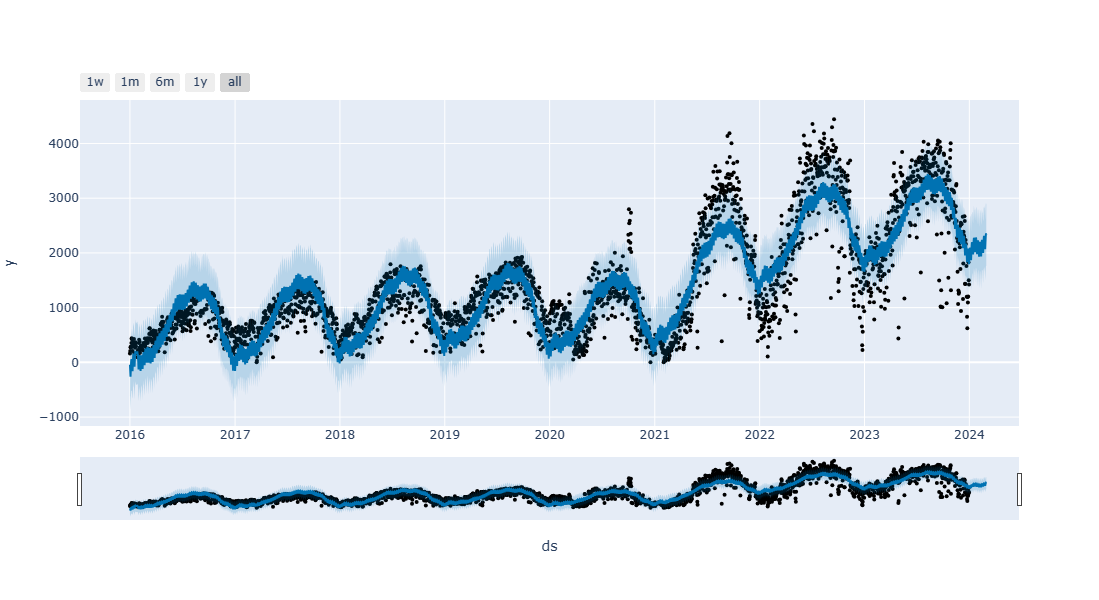

In [42]:
# This plot shows the forecast generated by the Prophet model.
plot_plotly(model ,forecast)

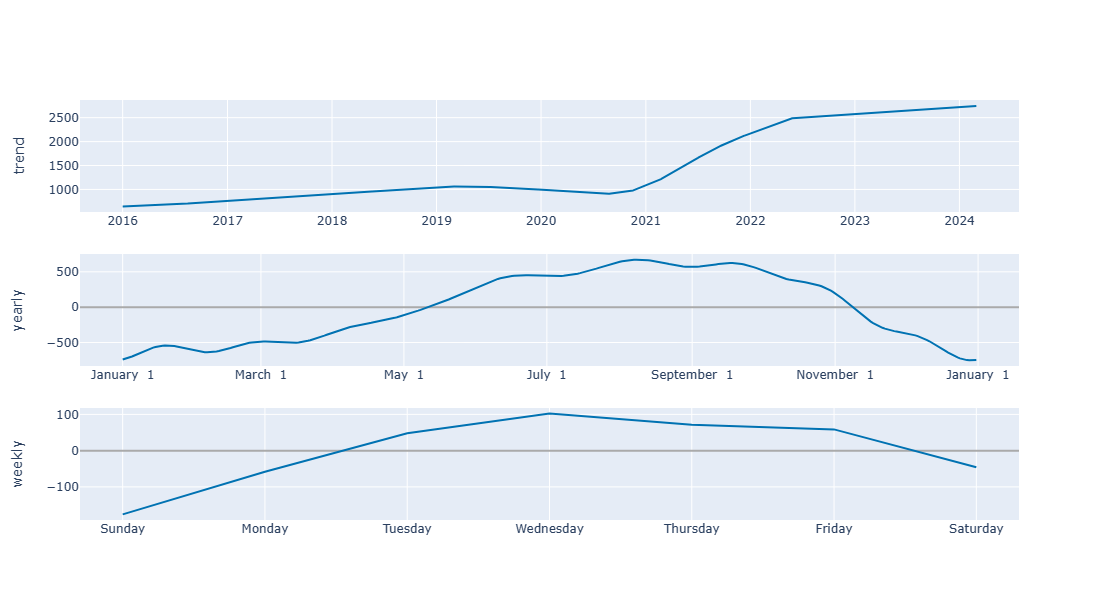

In [43]:
# This plot shows the yearly, weakly and general trend generated by the Prophet model.
plot_components_plotly(model, forecast)

In [44]:
# These are the predicted values for the year 2024.
predictions = forecast[forecast['ds'].dt.year == 2024]['yhat']
predictions

2913    1917.547160
2914    2031.265178
2915    2094.464715
2916    2074.618429
2917    2074.275856
2918    1983.346177
2919    1868.142794
2920    2000.887203
2921    2123.071839
2922    2192.698431
2923    2177.145577
2924    2178.917568
2925    2087.927994
2926    1970.543926
2927    2099.088173
2928    2215.199357
2929    2277.066400
2930    2252.291243
2931    2243.631972
2932    2141.280002
2933    2011.897308
2934    2128.111377
2935    2231.867793
2936    2281.657269
2937    2245.371109
2938    2226.037472
2939    2114.092253
2940    1976.410732
2941    2085.797775
2942    2184.336653
2943    2230.613331
2944    2192.570305
2945    2173.242361
2946    2063.028088
2947    1928.723251
2948    2043.013763
2949    2147.828230
2950    2201.566803
2951    2171.960311
2952    2161.811872
2953    2061.274685
2954    1936.891914
2955    2061.096252
2956    2175.568949
2957    2238.474902
2958    2217.327577
2959    2214.735866
2960    2120.686422
2961    2001.587286
2962    2129.770321


## Evaluation

In [45]:
# Calculate Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_true=test_data['y'], y_pred=predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 606.2713490186319


In [46]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true=test_data['y'],  y_pred=predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 462.4318641379783


In [47]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true=test_data['y'], y_pred=predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 0.38678867871851175


#### Plot comparing the actual and predicted values for the test data.

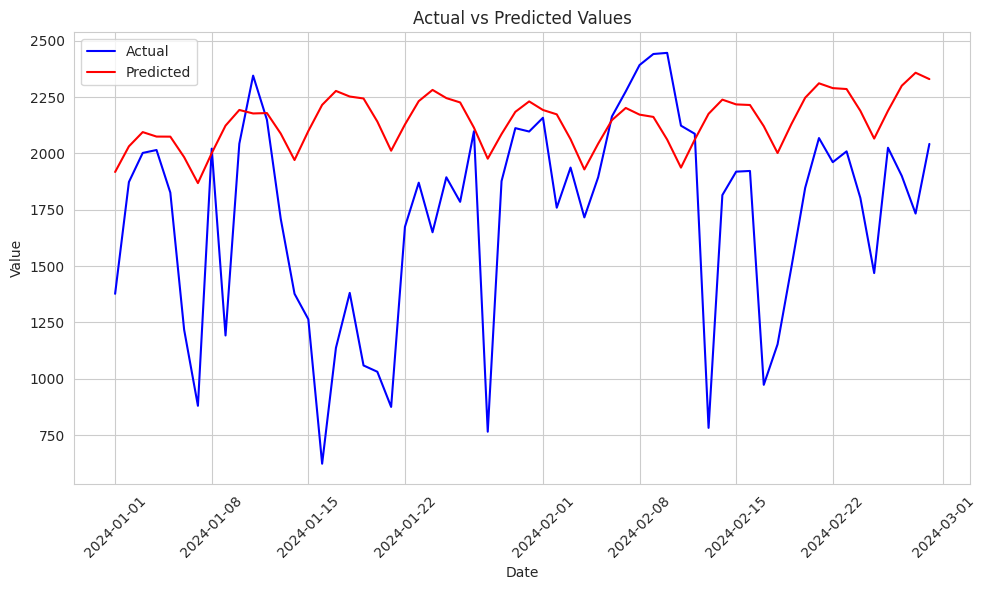

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45)  
plt.legend()
plt.tight_layout() 
plt.show()


# Adding Holidays/Special Events

In this section, we will see how adding holidays/Events effects the forecasted results

In [49]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

# Get the holidays
holidays = cal.holidays(start='2016-01-01', end='2024-02-29',return_name=True)

# Print the list of holidays
print("US Federal Holidays from 2016-2024:")
print(holidays)

US Federal Holidays from 2016-2024:
2016-01-01                         New Year's Day
2016-01-18    Birthday of Martin Luther King, Jr.
2016-02-15                  Washington's Birthday
2016-05-30                           Memorial Day
2016-07-04                       Independence Day
                             ...                 
2023-11-23                       Thanksgiving Day
2023-12-25                          Christmas Day
2024-01-01                         New Year's Day
2024-01-15    Birthday of Martin Luther King, Jr.
2024-02-19                  Washington's Birthday
Length: 86, dtype: object


In [50]:
holiday_df = pd.DataFrame(data=holidays,columns=['holiday'])

In [51]:
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})
holiday_df

ds                              holiday
0  2016-01-01                       New Year's Day
1  2016-01-18  Birthday of Martin Luther King, Jr.
2  2016-02-15                Washington's Birthday
3  2016-05-30                         Memorial Day
4  2016-07-04                     Independence Day
..        ...                                  ...
81 2023-11-23                     Thanksgiving Day
82 2023-12-25                        Christmas Day
83 2024-01-01                       New Year's Day
84 2024-01-15  Birthday of Martin Luther King, Jr.
85 2024-02-19                Washington's Birthday

[86 rows x 2 columns]

In [52]:
COVID_Pandemic = pd.DataFrame ({
    'ds':pd.date_range('2020-03-15','2023-03-01'),
     'holiday':'COVID'
})

COVID_Pandemic

ds holiday
0    2020-03-15   COVID
1    2020-03-16   COVID
2    2020-03-17   COVID
3    2020-03-18   COVID
4    2020-03-19   COVID
...         ...     ...
1077 2023-02-25   COVID
1078 2023-02-26   COVID
1079 2023-02-27   COVID
1080 2023-02-28   COVID
1081 2023-03-01   COVID

[1082 rows x 2 columns]

In [53]:
holiday_df = pd.concat((holiday_df,COVID_Pandemic))
holiday_df

ds                              holiday
0    2016-01-01                       New Year's Day
1    2016-01-18  Birthday of Martin Luther King, Jr.
2    2016-02-15                Washington's Birthday
3    2016-05-30                         Memorial Day
4    2016-07-04                     Independence Day
...         ...                                  ...
1077 2023-02-25                                COVID
1078 2023-02-26                                COVID
1079 2023-02-27                                COVID
1080 2023-02-28                                COVID
1081 2023-03-01                                COVID

[1168 rows x 2 columns]

In [54]:
model_with_holiday=Prophet(holidays=holiday_df)   # adding holiday factor to prophet
model_with_holiday.fit(train_data)

20:59:48 - cmdstanpy - INFO - Chain [1] start processing
20:59:48 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
future = model_with_holiday.make_future_dataframe(periods=60)  #makeing predictions
forecast = model_with_holiday.predict(future)

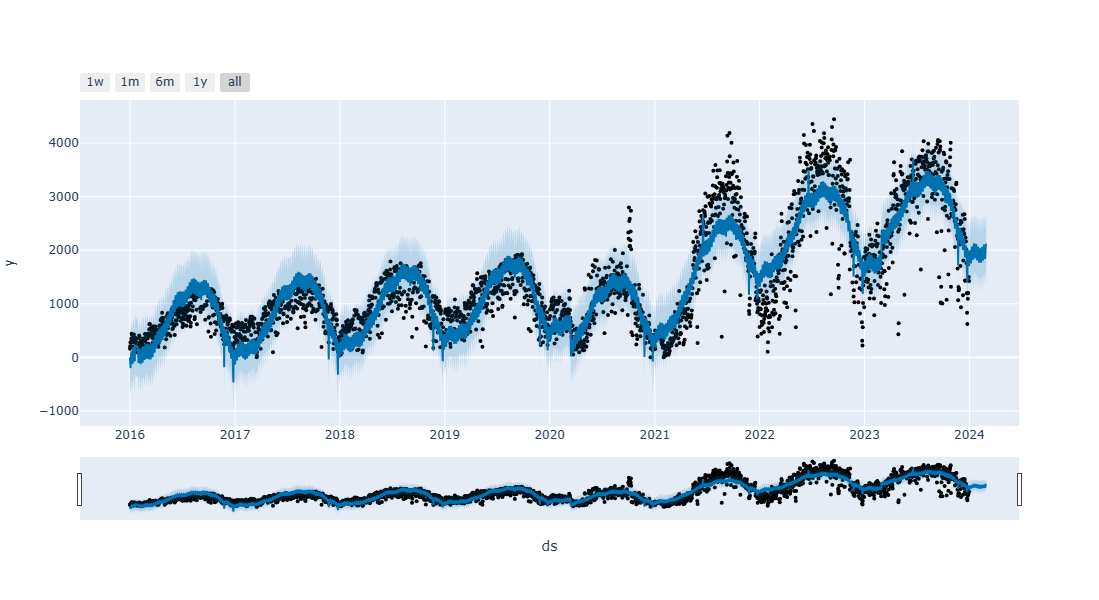

In [56]:
plot_plotly(model_with_holiday ,forecast)

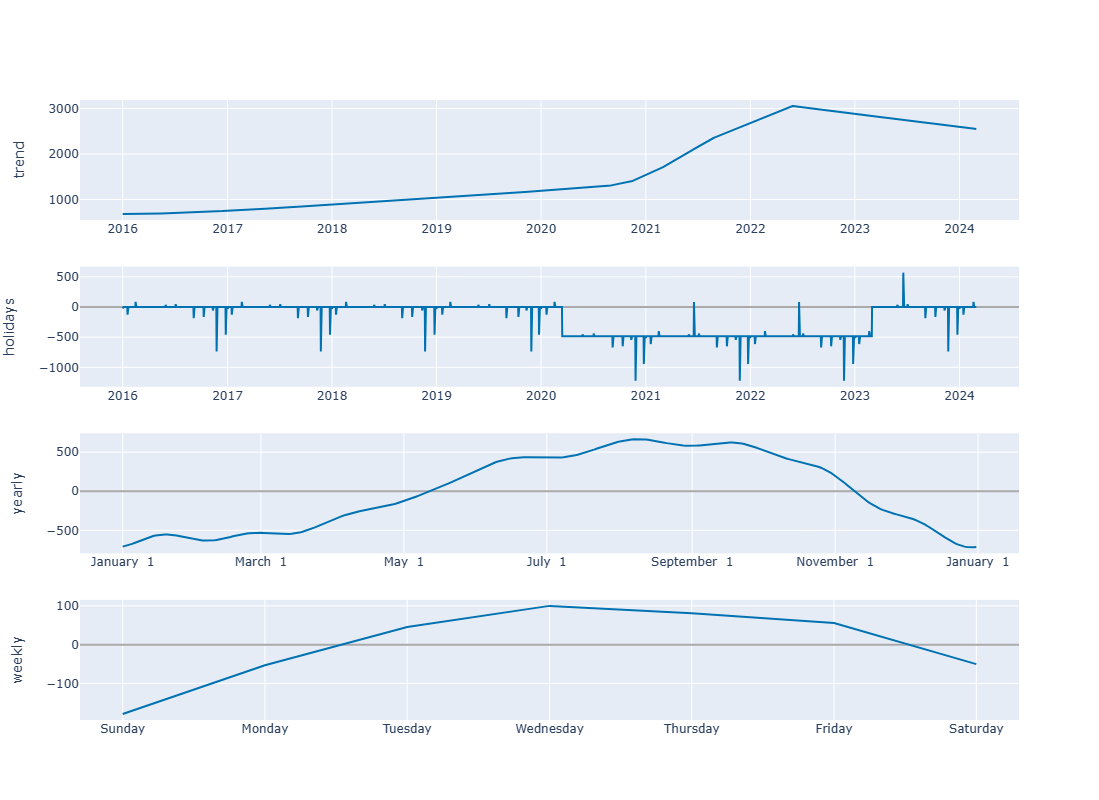

In [57]:
plot_components_plotly(model_with_holiday, forecast)

In [58]:
predictions = forecast[forecast['ds'].dt.year == 2024]['yhat']
predictions

2913    1807.764002
2914    1935.025415
2915    1995.808489
2916    1984.817398
2917    1968.402505
2918    1872.524328
2919    1754.735097
2920    1892.028422
2921    2002.234401
2922    2068.003519
2923    2060.165300
2924    2045.053997
2925    1948.655478
2926    1828.587881
2927    1834.025558
2928    2066.710486
2929    2125.694200
2930    2109.930251
2931    2085.975645
2932    1980.055935
2933    1850.039883
2934    1973.281029
2935    2068.003708
2936    2117.277091
2937    2092.363490
2938    2060.033447
2939    1946.702058
2940    1810.399359
2941    1928.608390
2942    2019.648552
2943    2066.647903
2944    2040.890648
2945    2009.132377
2946    1897.737471
2947    1764.651474
2948    1887.241966
2949    1983.685502
2950    2036.944120
2951    2018.117599
2952    1993.763844
2953    1890.041725
2954    1764.688981
2955    1894.868613
2956    1998.561159
2957    2058.546241
2958    2045.759409
2959    2026.616585
2960    1927.160285
2961    1805.040200
2962    2023.151578


## Evaluation

In [59]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true=test_data['y'], y_pred=predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 506.8814310552282


In [60]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true=test_data['y'],  y_pred=predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 366.41963944896645


In [61]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true=test_data['y'], y_pred=predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 0.31313136079423265


#### Plot comparing the actual and predicted values for the test data.

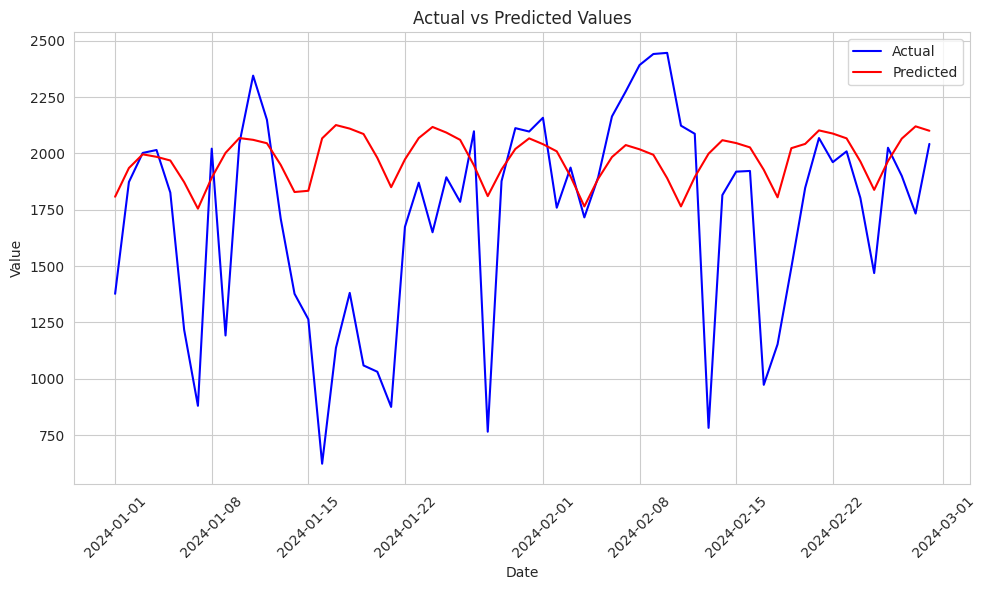

In [62]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values with dates
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


## Adding Weather Effect

In [63]:
weather_object = spark.read.csv('data/weather.csv', sep=',',inferSchema=True, header=True)
weather_object=weather_object.select("DATE","PRCP","SNOW")
weather_object

DataFrame[DATE: date, PRCP: double, SNOW: double]

In [64]:
start_date = '2016-01-01'
end_date = '2024-02-29'
weather_df = weather_object.filter((col('DATE') >= start_date) & (col('DATE') <= end_date))
weather_object

DataFrame[DATE: date, PRCP: double, SNOW: double]

In [65]:
# Merge trip data with weather data
weather_df = weather_df.withColumn('DATE', weather_df['DATE'].cast('timestamp'))
trips_df_spark = spark.createDataFrame(trips_df_pd)
merged_df = trips_df_spark.join(weather_df, trips_df_spark['ds'] == weather_df['DATE'], how='left')
merged_df = merged_df.drop('DATE')
merged_df_pd=merged_df.toPandas()
merged_df_pd['ds'] = pd.to_datetime(merged_df_pd['ds'])
merged_df_pd

ds     y   PRCP  SNOW
0    2016-01-01   163    0.0   0.0
1    2016-01-02   207    0.0   0.0
2    2016-01-03   276    0.0   0.0
3    2016-01-04   286    0.0   0.0
4    2016-01-05   273    0.0   0.0
...         ...   ...    ...   ...
2968 2024-02-25  1469    0.0   0.0
2969 2024-02-26  2025    3.0   0.0
2970 2024-02-27  1900  132.0   0.0
2971 2024-02-28  1733   43.0   0.0
2972 2024-02-29  2042    0.0   0.0

[2973 rows x 4 columns]

In [66]:
train_data = merged_df_pd[merged_df_pd['ds'].dt.year != 2024]
test_data = merged_df_pd[merged_df_pd['ds'].dt.year == 2024]

print("Training Dataset Size:", len(train_data))
print("Testing Dataset Size:", len(test_data))

Training Dataset Size: 2913
Testing Dataset Size: 60


In [67]:
model_weather=Prophet(holidays=holiday_df)  # adding holidays effects
model_weather.add_regressor('PRCP')         # adding precipitation effect
model_weather.add_regressor('SNOW')         # adding snow effect
model_weather.fit(train_data)

20:59:57 - cmdstanpy - INFO - Chain [1] start processing
20:59:57 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
def weather_PRCP(date):
    date = date.to_pydatetime().date()
    
    # Check if the date exists in historical weather data
    if weather_df.filter(weather_df['DATE'] == date).count() > 0: 
        return weather_df.filter(weather_df['DATE'] == date).select('PRCP').collect()[0]['PRCP'] #fetch the corresponding precipitate value
    else:
        return 0

def weather_SNOW(date):
    date = date.to_pydatetime().date()
    
    # Check if the date exists in historical weather data
    if weather_df.filter(weather_df['DATE'] == date).count() > 0: 
        return weather_df.filter(weather_df['DATE'] == date).select('SNOW').collect()[0]['SNOW'] #fetch the corresponding snow value
    else:
        return 0

In [ ]:
future = model_weather.make_future_dataframe(periods=60)  #makeing predictions
future['PRCP'] = future['ds'].apply(weather_PRCP)
future['SNOW'] = future['ds'].apply(weather_SNOW)
forecast = model_weather.predict(future)

In [ ]:
plot_plotly(model_weather ,forecast)

In [ ]:
plot_components_plotly(model_weather, forecast)

In [ ]:
predictions = forecast[forecast['ds'].dt.year == 2024]['yhat']
predictions

## Evaluation

In [ ]:
# Calculate Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_true=test_data['y'], y_pred=predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

In [ ]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true=test_data['y'],  y_pred=predictions)
print("Mean Absolute Error (MAE):", mae)

In [ ]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true=test_data['y'], y_pred=predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)

#### Plot comparing the actual and predicted values for the test data.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45)  
plt.legend()
plt.tight_layout() 
plt.show()